In [1]:
import numpy as np
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.ndimage import zoom
from importlib import reload
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF

import sys
sys.path.append('/home/plcristille/dev/utils')
import plot
from plot import load_dataset_SYNTHETIC_NOISY, load_unmixed_dataset_SYNTHETIC, plot_sampled_images, plot_spec, norm_hypercube, return_mixture, noise_data_for_snr, add_poisson_noise
sys.path.append('/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case')
import instrument_models
from instrument_models import Spectrometer_Model, Imager_Model, Mirim_Model_For_Fusion, Spectro_Model_3


sys.path.append('/home/plcristille/dev/JWST/Instrument_func/')
import functions_for_fusion_end_to_end
from functions_for_fusion_end_to_end import Mirim_Model_Cube, Spectro_Model_Cube, Mirim_Model_Cube_for_Tensors, Spectro_Model_Cube_for_Tensors, maps_to_cube, np_to_var, min_not_zero, rescale_0_1, var_to_np


In [2]:
def unmix(im, num_endmembers=5, max_iter_NMF=1e20, scaler=None, alpha_W=1e-1, alpha_H='same', l1_ratio=0.0):
    shape = im[None,...].shape
    pixels = im.transpose(1,2,0).reshape(-1, shape[1])
    
    if scaler==1:
        scaler = MinMaxScaler()
        pixels = scaler.fit_transform(pixels)
    elif scaler==0:
        scaler = (im.min(), im.max())
        pixels = norm_hypercube(pixels)

    nmf = NMF(n_components=num_endmembers, init='nndsvd', random_state=42, max_iter=int(max_iter_NMF), alpha_W=alpha_W, alpha_H=alpha_H, l1_ratio=l1_ratio)
    A = nmf.fit_transform(pixels).reshape(shape[2], shape[3], num_endmembers).transpose(2,0,1)
    E = nmf.components_  

    return A,E,scaler

In [3]:
wavelength_NIRSpec = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_wave.npy")
NIRCam_pce = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/PCE/NIRCam/NIRCam_PCE.npy")
NIRCam_PSF = np.load("/home/plcristille/dev/Webb_PSF/Saved_PSFs/instNIRCam_psfs_pixscale0.15000000000000002_fov6.000000000000001_nb28.npy")
NIRSpec_PSF = np.load("/home/plcristille/dev/Webb_PSF/Saved_PSFs/instNIRSpec_psfs_pixscale0.15000000000000002_fov6.000000000000001_nb1106.npy")
L_pce_NIRSpec = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/PCE/NIRSpec/NIRSpec_PCE.npy")
mixture_specs = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_spectra/test_signatures.npy")
size = (40,40)
di, dj = 2, 2
margin = 8


x_old = np.linspace(0, 1, mixture_specs.shape[1])
x_new = np.linspace(0, 1, L_pce_NIRSpec.shape[0])

interp_func = interp1d(x_old, mixture_specs, kind='linear', axis=1, fill_value="extrapolate")
mixture_specs = interp_func(x_new)

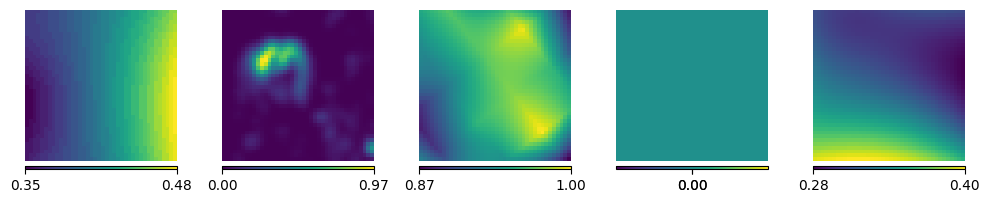

In [4]:
spat_ss = 2

fname_true_maps = "/home/plcristille/dev/JWST/Instrument_func/Abundance_maps_NEW.fits"
fits_cube = fits.open(fname_true_maps)
true_maps = np.asarray(fits_cube[0].data, dtype=np.float32)[:, ::spat_ss, :: spat_ss]
true_maps.shape

# MODIFYING ABUNDANCE MAP 1

true_maps[0][true_maps[0] > 0.8] = 0.8

# MODIFYING ABUNDANCE MAP 4

n_map = 3

map4 = true_maps[n_map]
# plt.imshow(map4)

d = 20
i1, j1 = 104, 202
# star1 = map4[i1 - d : i1 + d, j1 - d : j1 + d]
i2, j2 = 121, 318
# star2 = map4[i2 - d : i2 + d, j2 - d : j2 + d]
i3, j3 = 113, 345
# star3 = map4[i3 - d : i3 + d, j3 - d : j3 + d]
# star3.shape

mask = np.zeros((2 * d, 2 * d))
mask.shape

# plt.imshow(star3)

map4[i1 - d : i1 + d, j1 - d : j1 + d] = mask
map4[i2 - d : i2 + d, j2 - d : j2 + d] = mask
map4[i3 - d : i3 + d, j3 - d : j3 + d] = mask

# plt.imshow(map4)


# changing values of map 4
map4[map4 <= 0.35] = 0
min_not_zero_map_4 = min_not_zero(map4)
map4[map4 == 0] = min_not_zero_map_4
map4_rescaled = rescale_0_1(map4)

map4_rescaled_blurred = gaussian_filter(map4_rescaled, 1.4)

map4_rerescaled = rescale_0_1(map4_rescaled_blurred)

true_maps[n_map] = map4_rerescaled

shape_target = true_maps.shape[1:]

# IF SUBSAMPLING
# true_maps = true_maps[:, ::2, ::2]
# rect_ld = (152,40,size[0],size[1])

# ELSE
rect_ld = (310,100,size[0],size[1])

true_maps = true_maps[:, rect_ld[1]:rect_ld[1]+size[1], rect_ld[0]:rect_ld[0]+size[0]]
plot_sampled_images(true_maps, nb_columns=5, cbar=True, cbar_position='bottom', size=(10,5))

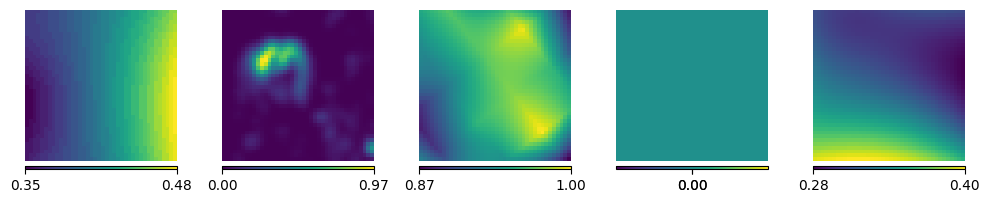

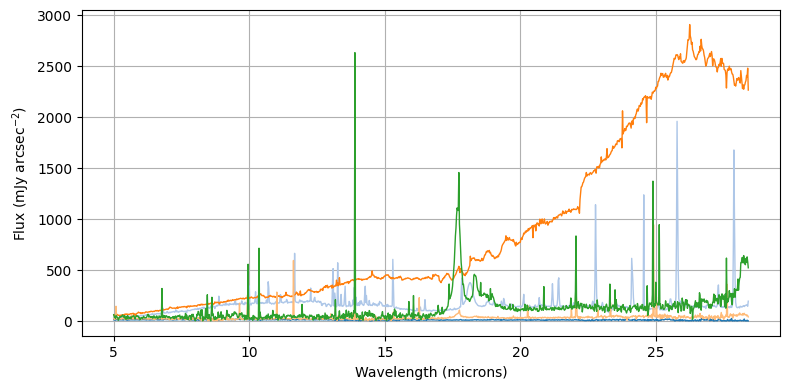

In [5]:
np.save("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/absolute_true_maps.npy",true_maps)
np.save("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/absolute_L_specs.npy",mixture_specs)

GT = return_mixture(mixture_specs, true_maps.T)
# maps, L_specs, scaler = unmix(GT, scaler=None, alpha_W=1e-3, alpha_H='same', l1_ratio=0.0)

maps, L_specs = true_maps, mixture_specs

plot_sampled_images(maps, nb_columns=5, cbar=True, cbar_position='bottom', size=(10,5))
plot_spec(L_specs)

In [6]:
# imager_model = Imager_Model(
#     NIRCam_PSF, NIRCam_pce, wavelength_NIRSpec, size, mixture_specs.shape[0], di, dj
# )
# spectro_model = Spectrometer_Model(
#     NIRSpec_PSF, L_pce_NIRSpec, wavelength_NIRSpec, size, mixture_specs.shape[0], di, dj
# )
# MS_2 = imager_model.forward(true_maps, mixture_specs)[:, margin//2:-margin//2, margin//2:-margin//2]
# HS_2 = spectro_model.forward(true_maps, mixture_specs)[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]


imager_model = Mirim_Model_For_Fusion(
    NIRCam_PSF, NIRCam_pce, wavelength_NIRSpec, L_specs, size, di, dj
)
spectro_model = Spectro_Model_3(
    NIRSpec_PSF, L_pce_NIRSpec, di, dj, wavelength_NIRSpec, L_specs, size
)
MS = imager_model.forward(maps)[:, margin//2:-margin//2, margin//2:-margin//2]
HS = spectro_model.forward(maps)[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]


GT = GT[:, margin//2:-margin//2, margin//2:-margin//2]


print(f"GT : {GT.shape}, MS : {MS.shape}, HS : {HS.shape}")
np.save(f"/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/GT_NIR_{GT.shape[0]}_{GT.shape[1]}.npy", GT)
np.save(f"/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/NIRCam_{GT.shape[0]}_{GT.shape[1]}.npy", MS)
np.save(f"/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/NIRSpec_{GT.shape[0]}_{GT.shape[1]}.npy", HS)

GT : (1106, 32, 32), MS : (28, 32, 32), HS : (1106, 16, 16)


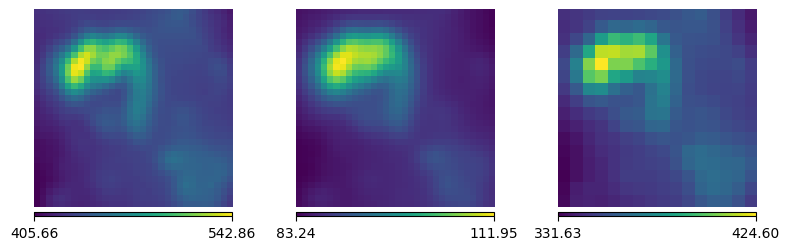

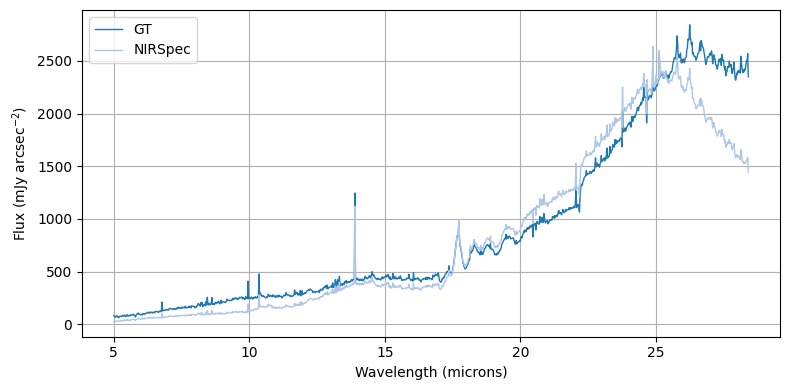

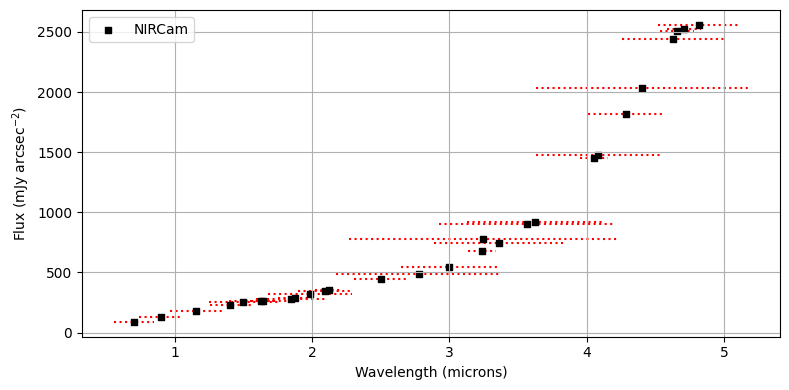

: 

In [ ]:
NOISE = False

if NOISE:
    snr_MS = 90
    snr_HS = 90
    snr_poisson = 150

    ms_poisson = add_poisson_noise(MS, [snr_poisson])
    hs_poisson = add_poisson_noise(HS, [snr_poisson])

    ms_final = noise_data_for_snr(ms_poisson, [snr_MS])[0][0]
    hs_final = noise_data_for_snr(hs_poisson, [snr_HS])[0][0]
else:
    snr_MS = "inf"
    snr_HS = "inf"
    ms_final = MS
    hs_final = HS


b_MS, b_HS = 0, 500

plot_sampled_images([GT[b_HS], ms_final[b_MS], hs_final[b_HS]], cbar=True, cbar_position='bottom')
plot_spec([GT.mean(axis=(1,2)), hs_final.mean(axis=(1,2))], filters=["GT", "NIRSpec"])
plot_spec([ms_final.mean(axis=(1,2))], filters=["NIRCam"])

In [39]:
# hs_noisy_inverted = (hs_noisy/L_pce_NIRSpec[:, np.newaxis, np.newaxis])/(L_pce_NIRSpec.max()*100)
A_hs, E_hs, scaler = unmix(hs_final, scaler=0, alpha_W=1e-6, alpha_H='same', l1_ratio=0.0)

# for u, unmixed_spec in enumerate(E_hs):
#     E_hs[u] = norm_hypercube(unmixed_spec, min_value=mixture_specs[u].min(), max_value=mixture_specs[u].max())

E_hs = norm_hypercube(E_hs, min_value=L_specs.min(), max_value=L_specs.max())

np.save(f"/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/lmm_specs_SNR{snr_HS}.npy", E_hs)
np.save("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/GT_specs.npy", L_specs)
np.save(f"/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/true_maps.npy", maps)
np.save("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/scaler.npy", scaler)

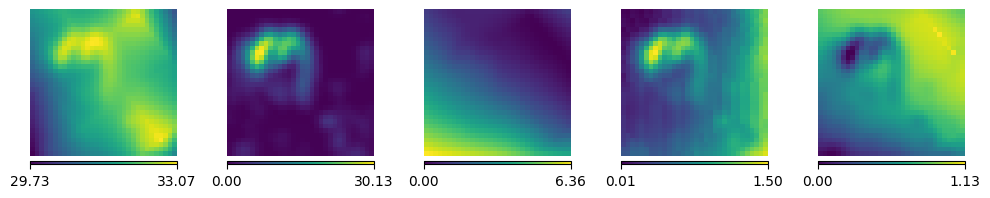

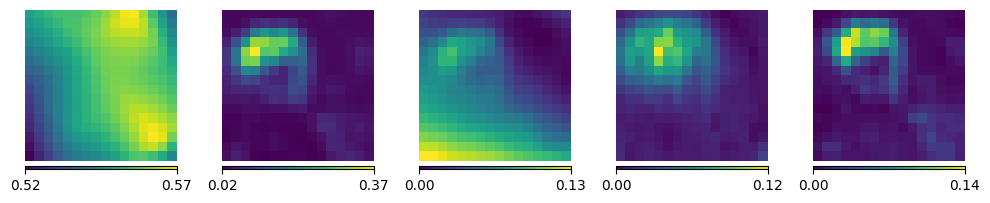

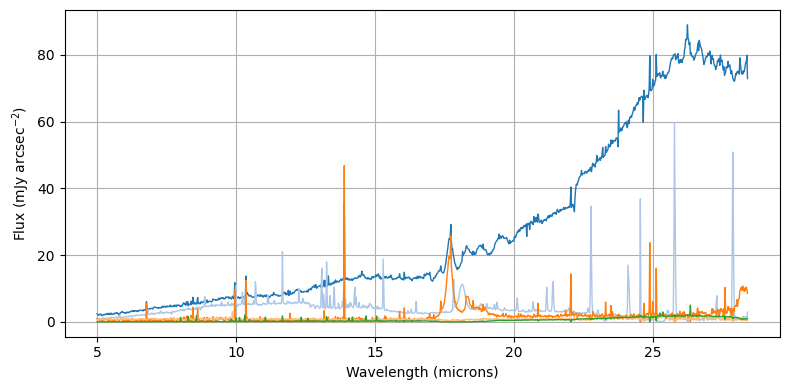

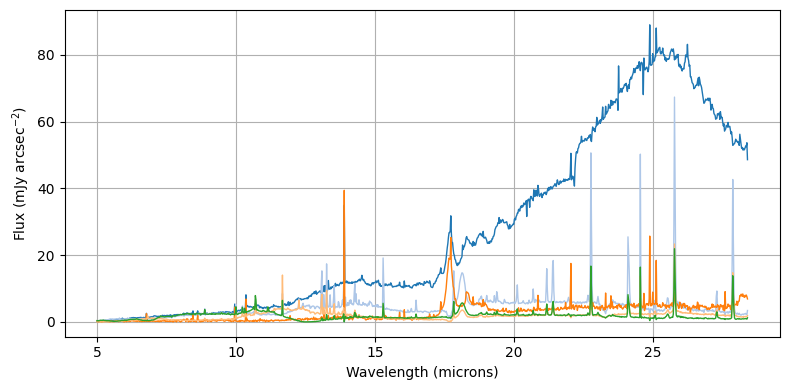

: 

In [ ]:
plot_sampled_images(maps[:, margin//2:-margin//2, margin//2:-margin//2], nb_columns=5, cbar=True, cbar_position='bottom', size=(10,5))
plot_sampled_images(A_hs, nb_columns=5, cbar=True, cbar_position='bottom', size=(10,5))
plot_spec(L_specs)
plot_spec(E_hs)